<div>
    <img style="float:right;" src="images/smi-logo.png"/>
    <div style="float:left;color:#58288C;"><h1>Datenanalyse und Datenmanagement</h1></div>
</div>

---
# Notebook IV: Data Analytics
In diesem Notebook geht es um die analytische Erschließung eines weiteren Datensatzes.
Die Merkmale werden aufbereitet, sodass im Anschluss Machine Learning Modelle entwickelt werden können.

## Inhaltsverzeichnis

[1. Einstieg: Research Approach](#kapitel1)  
[2. Datenaufbereitung](#kapitel2)  
[3. Modellbildung](#kapitel3)  
[4. Modellevaluation](#kapitel4)  
[5. Ausblick: Unsupervised K-Means Clustering](#kapitel5)  

---

## 1. Einstieg: Research Approach <a id="kapitel1"/>

- **Business Problem**: Nach Eingang eines Kreditantrags muss über die Vergabe und den angebotenen Zinssatz entschieden werden.  
Diese Entscheidung hängt vom angenommenen Ausfallrisiko des Kredits ab.
- **Research Problem**: Das Modell soll jeden Antrag klassifizieren: Risiko vs. kein-Risiko.  
Die Entscheidung über Vergabe und Zinssatz wird basierend auf dieser Information vom jew. Sachbearbeiter nach separat verfassten Richtlinien getroffen.
- **Trainingsdaten**: Vergangene Kreditanträge und Ausfall j/n

## 2. Datenaufbereitung <a id="kapitel2"/>

### 2.1. Daten einlesen
Auf bekannte Weise werden zunächst Pakete importiert und die Daten aus der Datenbank abgefragt.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisierung-Stil für Diagramme mit Seaview setzen
sns.set(font_scale = 1.1,
       palette     = "pastel", 
       style       = "whitegrid")

Zudem verwenden wir in diesem Notebook das Paket [scikit-learn](https://scikit-learn.org/stable/).

<a href="https://scikit-learn.org/stable/">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png" width=250/>
</a>

In [2]:
# Machine Learning Paket scikit-learn mit Modellen DecisionTree, Regression, K-Means Clustering
import sklearn
import sklearn.tree
import sklearn.linear_model
import sklearn.cluster

%matplotlib inline
%load_ext sql

In [3]:
# Verbindung zum Datenbankserver herstellen
%sql sqlite:///data/smi-data.db

# SQL-Abfrage durchführen und Ergebnis in Variable result speichern        
result = %sql SELECT * FROM credit_ger

# Aus Result ein DataFrame machen
df = result.DataFrame()

 * sqlite:///data/smi-data.db
Done.


Nun setzen wir den Primärschlüssel als Index des DataFrames und benennen die Merkmale griffiger (keiner Leerzeichen, nur Kleinschreibung, ...).

In [4]:
df = df.set_index(["id"])
df = df.rename({
    "Age": "age",
    "Sex": "sex",
    "Job": "job",
    "Housing": "housing",
    "Saving_accounts": "savings", 
    "Checking_account": "cash",
    "Credit_amount": "amount",
    "Duration": "duration",
    "Purpose": "purpose",
    "Risk": "risk"
}, axis="columns")
df.head(15)

,age,sex,job,housing,savings,cash,amount,duration,purpose,risk
id,,,,,,,,,,
0,67,male,2,own,NA,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NA,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NA,NA,9055,36,education,good
6,53,male,2,own,quite rich,NA,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NA,3059,12,radio/TV,good


Die Ausprägungen des Merkmals purpose scheinen sehr lang, daher kürzen wir diese, um in Diagrammen keine Platzprobleme mit Beschrifungen zu bekommen.

In [5]:
df.purpose.unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [6]:
df.purpose.replace({
    "furniture/equipment": "home/living",
    "domestic appliances": "home appl.",
    "vacation/others": "leisure"
}, inplace=True)

### 2.2. Feature Engineering

Worum geht es?
>Feature Engineering ist der Prozess, Merkmale für die Algorithmen möglichst gut zugänglich zu machen. Dabei fließt in der Regel Domänenwissen des Modellierers in den Datensatz ein.

In unserem Beispiel begnügen wir uns mit dem Minimum: Die gewählten Machine Learning Verfahren sollen technisch mit dem Datensatz umgehen können. 
So finden sich etwa mehere String-Merkmale (Skalenniveau "nominal") im Datensatz, mit denen nicht direkt gerechnet werden kann. Daher sind diese zweckmäßig in Zahlen umzukodieren.

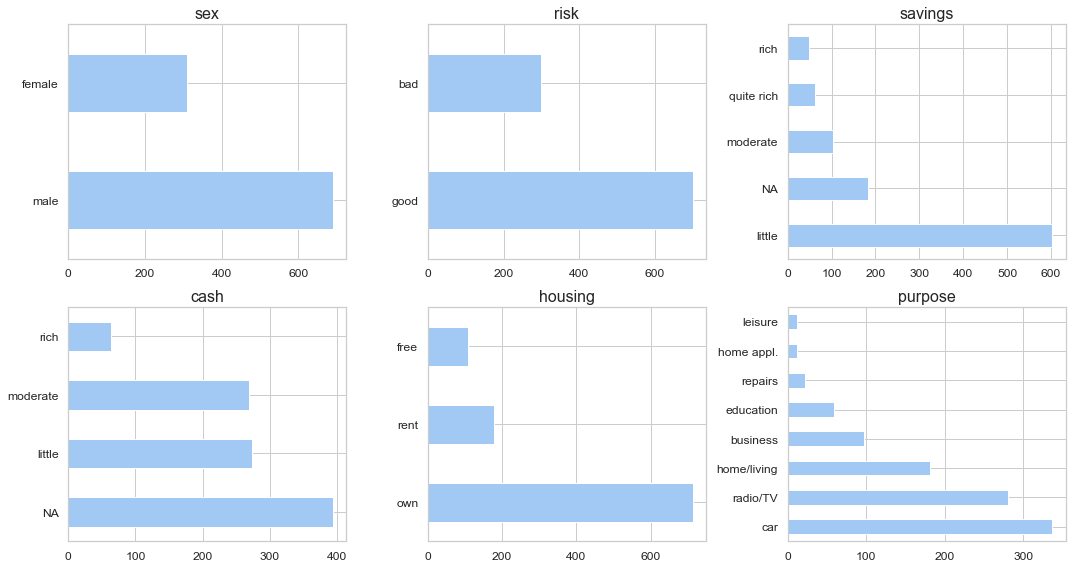

In [7]:
# Zunächst betrachten wir die fraglichen Merkmale genauer

binaere_merkmale = ["sex", "risk"]              # nominale Merkmale mit nur zwei Ausprägunen
nominale_merkmale = ["housing", "purpose"]
ordinale_merkmale = ["savings", "cash"]
metrische_merkmale = ["age", "amount", "duration"]

fig, ax = plt.subplots(2,3,figsize=(15,8))

for i, merkmal in enumerate(binaere_merkmale + ordinale_merkmale + nominale_merkmale):
    ax[i//3,i%3].set_title(merkmal, fontsize=16)
    df[merkmal].value_counts().plot(kind="barh", ax=ax[i//3,i%3])
plt.tight_layout()
plt.show()

In [8]:
# Zunächst erzeugen wir DataFrames für die aufbereiteten Trainingsdaten (X) 
# und Labels (y)

X = pd.DataFrame()   # "groß" X, da Struktur eine Matrix ist
y = pd.DataFrame()   # "klein" y, da Struktur ein Vektor ist

In [9]:
# Auf die binären Merkmale wenden wir die Dummykodierung an:

y["risk"] = (df.risk == "bad")*1   # *1 macht aus True/False 0/1
X["male"] = (df.sex == "male")*1   # *1 macht aus True/False 0/1

print(X.male.value_counts())
print("")
print(y.risk.value_counts())

1    690
0    310
Name: male, dtype: int64

0    700
1    300
Name: risk, dtype: int64


In [10]:
# Auf nominale und ordinale Merkmale mit mehreren Ausprägungen wenden wir One-Hot-Encoding an

beispiel = df["housing"]
one_hot_encoded = pd.get_dummies(beispiel, prefix="housing")
pd.concat([beispiel, one_hot_encoded], axis=1).head()

,housing,housing_free,housing_own,housing_rent
id,,,,
0,own,0,1,0
1,own,0,1,0
2,own,0,1,0
3,free,1,0,0
4,free,1,0,0


In [11]:
# Anwendung auf verbleibende Merkmale und Überführung in DataFrame X

# Strings in der Purpose-Spalte kürzen, damit die Merkmalsbezeichnungen nicht zu lang werden

df.purpose = df.purpose.str.slice(0,8)

kodierte_merkmale = pd.get_dummies(df[nominale_merkmale + ordinale_merkmale], prefix=["house","purpose","savings","cash"])
X = pd.concat([X, kodierte_merkmale], axis=1)

X.head()

,male,house_free,house_own,house_rent,purpose_business,purpose_car,purpose_educatio,purpose_home app,purpose_home/liv,purpose_leisure,...,purpose_repairs,savings_NA,savings_little,savings_moderate,savings_quite rich,savings_rich,cash_NA,cash_little,cash_moderate,cash_rich
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


<AxesSubplot:ylabel='Count'>

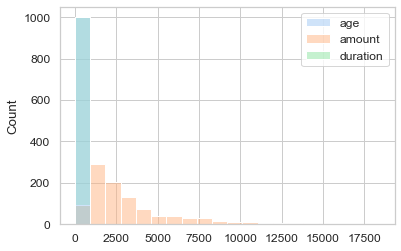

In [12]:
# Die metrischen Merkmale haben deutlich verschiedene Spannweiten

sns.histplot(df.loc[:,metrische_merkmale], bins=20, alpha=0.5)

Durch [Z-Standardisierung](https://de.wikipedia.org/wiki/Standardisierung_(Statistik)) (Normierung auf Mittelwert 0 und Standardabweichung 1) bleiben die Informationen erhalten und anfällige Algorithmen gewichten Merkmale mit großen Zahlausprägungen nicht implizit höher.

<AxesSubplot:ylabel='Count'>

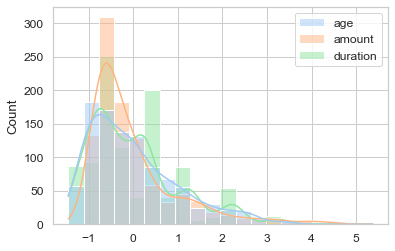

In [13]:
for merkmal in metrische_merkmale:
    X[merkmal] = (df[merkmal]-df[merkmal].mean()) / df[merkmal].std()

sns.histplot(X.loc[:,metrische_merkmale], bins=20, kde=True, alpha=0.5)

In [14]:
# Vergleich vorher (unnormiert) / nachher (Z-Standardisiert)
pd.concat([df.loc[:,metrische_merkmale],
          X.loc[:,metrische_merkmale]], axis=1).head(5)

,age,amount,duration,age,amount,duration
0,67,1169,6,2.765073,-0.744759,-1.235859
1,22,5951,48,-1.190808,0.949342,2.247070
2,49,2096,12,1.182721,-0.416354,-0.738298
3,45,7882,42,0.831087,1.633430,1.749509
4,53,4870,24,1.534354,0.566380,0.256825


## 3. Modellbildung <a id="kapitel3"/>
Im ersten Schritt teilen wir unsere Trainingsdaten in Trainings- und Testdaten.  
Die Testdaten enthalten wir dem Modell zunächst vor und verwenden sie nach der Modellierung zur Gütebewertung des Modells.

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)   # 20% Testdaten
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(800, 24)
(200, 24)
(800, 1)
(200, 1)


### 3.1. Supervised Learning: Decision Tree
Ziel soll nun sein, das Kreditrisiko aus den anderen Merkmalen mittels eines Entscheidungsbaums vorherzusagen.  

In [16]:
tree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=20)
tree = tree.fit(X_train, y_train)    # zur Erinnerung: X enthält unsere aufbereiteten Fallmerkmale, Y die "Labels", also risk 0 oder 1

Visualisieren wir nun den Baum um die Art der Regeln zu begutachten. Jeder Knoten enthält dabei folgende Werte:
- Split-Kriterium
- Gini-Koeffizient (ignorieren wir im Rahmen dieser Veranstaltung)
- Anteil der Fälle in diesem Knoten
- Anteil der Fälle mit risk 0 und risk 1
- Entscheidung für welche Klasse (y0, y1)

Der linke Pfeil bedeutet "True", der rechte Pfeil "False" bezogen auf das Knotenkriterium.

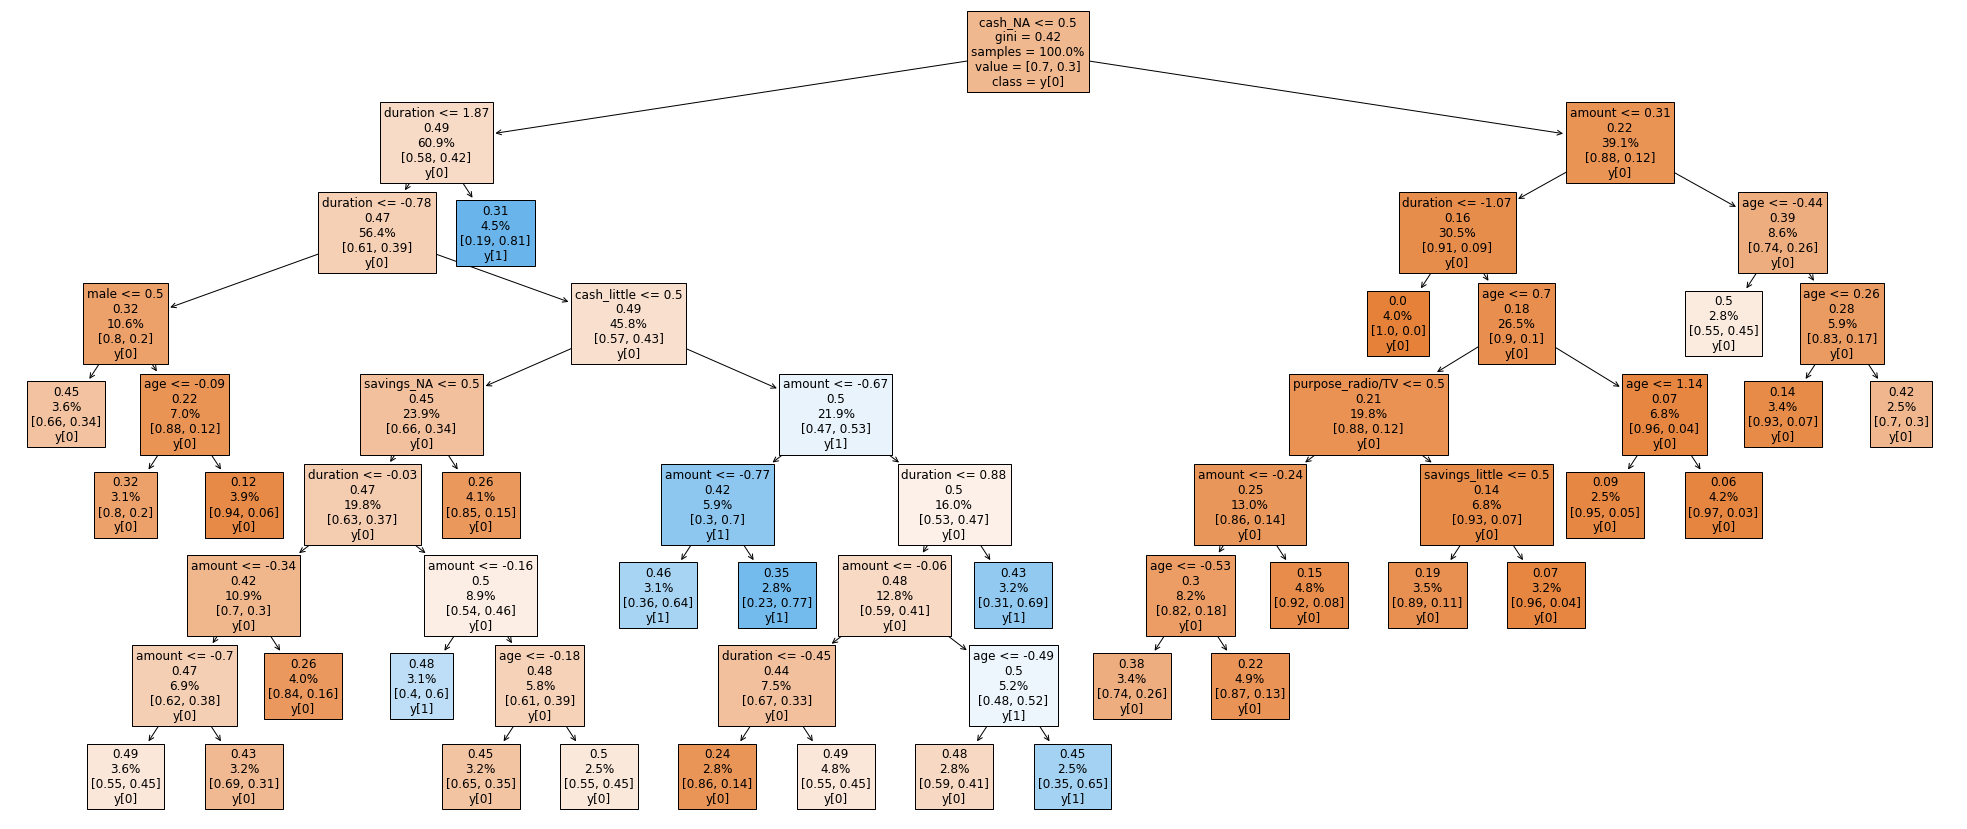

In [17]:
fig, ax = plt.subplots(1,1,figsize=(35,15))
plt.style.use('default')  # Bug in scikit-learn: Wenn Seaborn-Style gesetzt, wird der Tree nicht korrekt dargestellt, daher erst zurücksetzen
t = sklearn.tree.plot_tree(tree, ax=ax, class_names=True, label="root", precision=2, feature_names=X.columns, fontsize=12, proportion=True, filled=True)
plt.show()

### 3.2. Supervised Learning: Logistische Regression

Zum Vergleich führen wir parallel eine Logistische Regression durch (lineare Regression für Klassifikation).

In [18]:
reg = sklearn.linear_model.LogisticRegression()
reg = reg.fit(X_train, y_train.values.ravel())

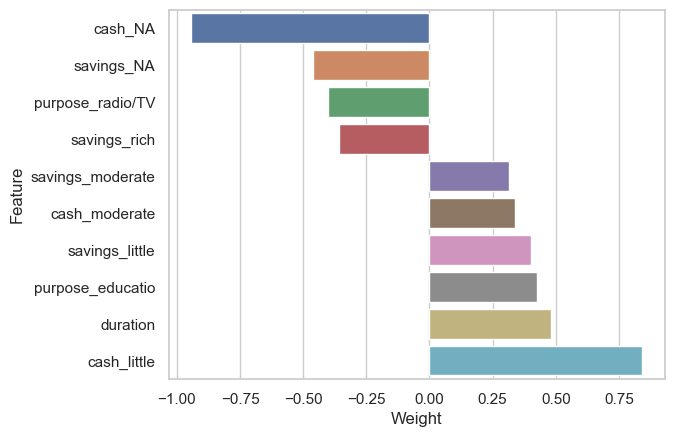

In [19]:
# Die Regression schätzt für jedes Datensatzmerkmal einen Gewichtungsfaktor zur Berechnung der Klasse.
# Zur Visualisierung der Feature-Bedeutung übernehmen wir die Merkmalsbezeichnungen aus den Trainingsdaten X

stat = pd.DataFrame([X.columns, reg.coef_.ravel()]).transpose()
stat = stat.sort_values(by=[1])
stat = stat[abs(stat[1])>0.3]   # only important parameters
sns.set(style = "whitegrid")
ax = sns.barplot(y=0, x=1, data=stat, orient="h")
ax.set(xlabel='Weight', ylabel='Feature')
plt.show()

## 4. Modellevaluation <a id="kapitel"/>

### 4.1. Average Precision
Als vermutlich einfachste Kennzahl können wir uns zu Modellen die durchschnittliche Treffergenauigkeit (% der Fälle die korrekt klassifiziert wurden) angeben lassen:

In [20]:
print("Average Precision DecisionTree: {} bei Trainingsdaten, {} bei Testdaten".format(
    tree.score(X_train, y_train), 
    tree.score(X_test, y_test)))

print("Average Precision Regression: {} bei Trainingsdaten, {} bei Testdaten".format(
    reg.score(X_train, y_train), 
    reg.score(X_test, y_test)))

Average Precision DecisionTree: 0.775 bei Trainingsdaten, 0.725 bei Testdaten
Average Precision Regression: 0.74375 bei Trainingsdaten, 0.745 bei Testdaten


---

**ACHTUNG**: Wo könnte diese Zahl im vorliegenden Fall irreführen?

---

### 4.2. Confusion Matrix
Um die Güte bei Klassifikationsproblemen genauer zu untersuchen, können wir die Testdaten betrachten.  
Die Confusion Matrix zeigt, wie oft die Modelle je Klasse (risk 0 oder 1) richtig und falsch lagen.

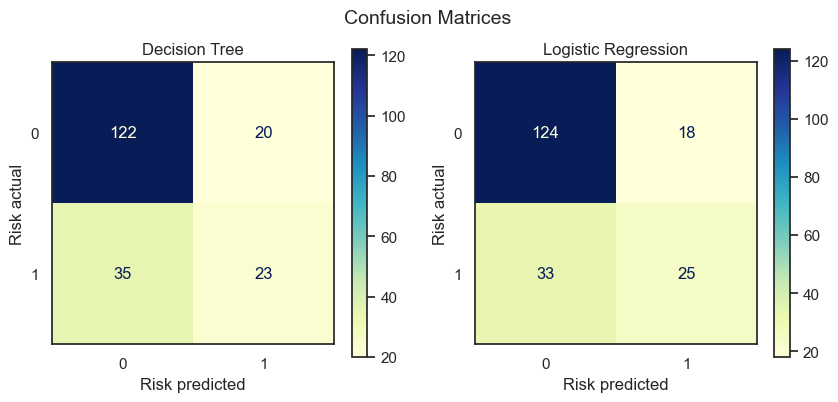

In [21]:
sns.set(style       = "white")
fig, ax = plt.subplots(1,2,figsize=(10,4))
plt.suptitle("Confusion Matrices", fontsize=14)
ax[0].set_title("Decision Tree")
ax[1].set_title("Logistic Regression")
sklearn.metrics.plot_confusion_matrix(tree, X_test, y_test, ax=ax[0], cmap="YlGnBu")
ax[0].set_xlabel("Risk predicted")
ax[0].set_ylabel("Risk actual")
sklearn.metrics.plot_confusion_matrix(reg, X_test, y_test, ax=ax[1], cmap="YlGnBu")
ax[1].set_xlabel("Risk predicted")
ax[1].set_ylabel("Risk actual")
plt.show()

Es zeigt sicht, dass ein Großteil der korrekt klassifizierten Fälle in der Klasse Risk=0 liegen.

### 4.3. Precision und Recall
Bei näherer Betrachtung interessieren uns aus der Confusion Matrix zwei Facetten der Fehler, die wir als zwei Fragen formulieren können:
- Wieviel % haben wir richtigerweise beschuldigt?
- Wieviel % der Risikokredite haben wir entdeckt?

Diese Fragen werden durch die Metriken Precision und Recall beantwortet ([mehr dazu hier](https://en.wikipedia.org/wiki/Precision_and_recall)):
- **Precision**: Anteil der tatsächliche Kreditrisiken unter den vorhergesagten Kreditrisiken  
- **Recall**: Anteil der erkannten Risiken unter allen Risikokrediten  

Aus betriebswirtschaftlicher Sicht sind die Fehlerarten von verschiedenem Gewicht:
- Precision: fälschlicherweise angenommenes Risiko (Feld Actual = 0, Predicted = 1) => entgangenes Geschäft
- Recall: nicht erkanntes Risiko bedeutet Kreditausfall (Feld Actual = 1, Predicted = 0) => hohe finanzielle Einbußen

Der schwerste Schaden entsteht vermutlich bei nicht erkannten Risiken und damit verbundenem Kreditausfall. Daher wäre das Gütekriterium Recall höher zu gewichten als Precision.

In [22]:
tree_precision = sklearn.metrics.precision_score(y_test.values.ravel(), tree.predict(X_test))
tree_recall    = sklearn.metrics.recall_score(y_test.values.ravel(), tree.predict(X_test))

reg_precision = sklearn.metrics.precision_score(y_test.values.ravel(), reg.predict(X_test))
reg_recall    = sklearn.metrics.recall_score(y_test.values.ravel(), reg.predict(X_test))

print("Tree:       Precision {:.2f}%, Recall {:.2f}%".format(100 * tree_precision, 100 * tree_recall))
print("Regression: Precision {:.2f}%, Recall {:.2f}%".format(100 * reg_precision, 100 * reg_recall))

Tree:       Precision 53.49%, Recall 39.66%
Regression: Precision 58.14%, Recall 43.10%


### 4.4. Untersuchung der Modellfehler
Um Verbesserungsmöglichkeiten zu finden, können wir uns die größten Fehler des Modells ansehen.  
Dabei ist es empfehlenswert die falsch klassifizierten Testdaten zu betrachten. Da wir im vorliegenden Beispiel jedoch zu wenig Testdaten haben, betrachten wir zu Demonstrationszwecken die Fehler in den Trainingsdaten.

In [23]:
Y_pred = tree.predict(X_train)                                   # Für Testdatensätze die Klassifikation des Trees berechnen
Y_prob = tree.predict_proba(X_train)                             # Für Testdatensätze die Wahrscheinlichkeiten für Klassen 0 und 1 berechnen
df_pred = pd.DataFrame(Y_pred, columns=["prediction"])          # Wahrscheinlichkeiten und Zielklasse in DataFrame überführen und Spalten labeln
df_prob = pd.DataFrame(Y_prob, columns=["Prob_0", "Prob_1"])
df_err = pd.concat([X_test, y_test, df_pred, df_prob], axis=1) # Diagnose-DataFrame aus Test-Merkmalen, der wahren Klasse und den Wahrscheinlichkeiten zusammenstellen

df_err.dropna(inplace=True)                                    # Dataset hat immer noch 1000 Rows, Trainingsdaten wurd nur "NaN" ersetzt. Diese Zeilen entfernen

df_err = df_err[df_err.risk != df_err.prediction]
df_err["error_size"] = df_err[["Prob_0","Prob_1"]].max(axis=1)

df_err.sort_values("error_size", ascending=False)

,male,house_free,house_own,house_rent,purpose_business,purpose_car,purpose_educatio,purpose_home app,purpose_home/liv,purpose_leisure,...,cash_moderate,cash_rich,age,amount,duration,risk,prediction,Prob_0,Prob_1,error_size
653,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.567361,1.705700,1.251947,1.0,0.0,0.970588,0.029412,0.970588
466,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.575449,-0.571168,0.256825,1.0,0.0,0.970588,0.029412,0.970588
788,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.270629,1.046056,2.247070,1.0,0.0,0.970588,0.029412,0.970588
315,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.399632,-0.186081,1.251947,1.0,0.0,0.970588,0.029412,0.970588
580,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.487540,-0.784791,-0.240737,1.0,0.0,0.961538,0.038462,0.961538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.102900,-0.813132,-0.240737,1.0,0.0,0.551724,0.448276,0.551724
175,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.534354,1.492786,0.754386,1.0,0.0,0.550000,0.450000,0.550000
796,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.358537,1.501997,-0.240737,1.0,0.0,0.550000,0.450000,0.550000
624,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.589256,-0.237804,-0.240737,1.0,0.0,0.545455,0.454545,0.545455


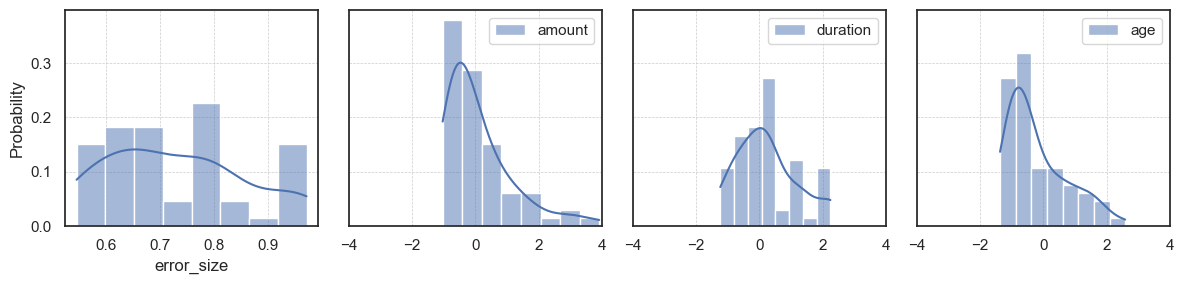

In [24]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,3))

sns.histplot(df_err.error_size,   stat="probability", bins=8, kde=True, ax=ax[0])
sns.histplot(df_err.loc[:,["amount"]],   stat="probability", bins=8, kde=True, ax=ax[1])
sns.histplot(df_err.loc[:,["duration"]], stat="probability", bins=8, kde=True, ax=ax[2])
sns.histplot(df_err.loc[:,["age"]],      stat="probability", bins=8, kde=True, ax=ax[3])

[a.set_xlim(-4,4) for a in ax[-3:]]
[a.grid(linestyle="--", linewidth=.5) for a in ax]

plt.tight_layout()
plt.show()

### <span style="color:#FF5D02;">Quick Task: Interpretation</span>
Wie ist diese Darstellung zu falsch klassifizierten Kredite zu interpretieren? Wie könnte man vorgehen, um Maßnahmen zur Verbesserung des Modells zu entwickeln?

## 5. Ausblick: Unsupervised K-Means Clustering <a id="kapitel5" />

### 5.1. Optimale Clusteranzahl bestimmen

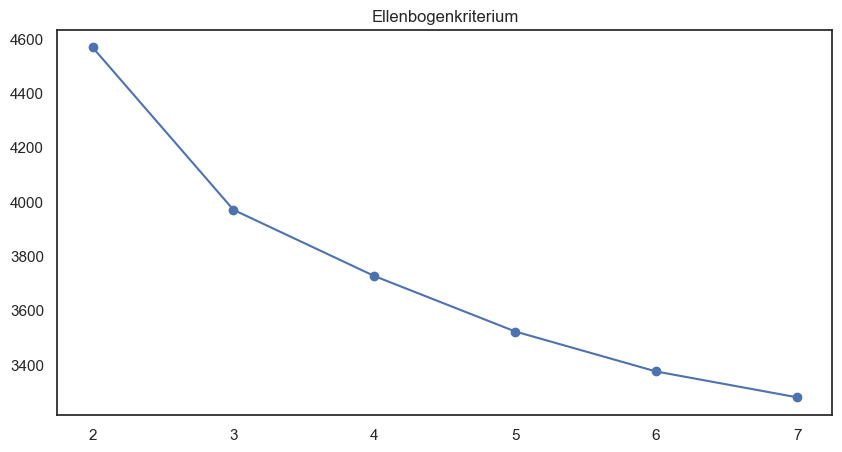

In [25]:
inertias = []   # Inertia ist die Distanz der zuletzt fusionierten Cluster

for i in range(2,8):  # Erzeuge mehrere Clusterlösungen mit 2-8 Clustern
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)  # Hänge den Inertia-Wert an unsere Liste inertias

plt.figure(figsize=(10,5))   # Inertia plotten
plt.title('Ellenbogenkriterium')
plt.plot(range(2,8), inertias, marker="o");

### 5.2. K-Means Clustering durchführen

In [26]:
# 3 Cluster sehen gut aus!
kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X)
df["clusters"] = clusters

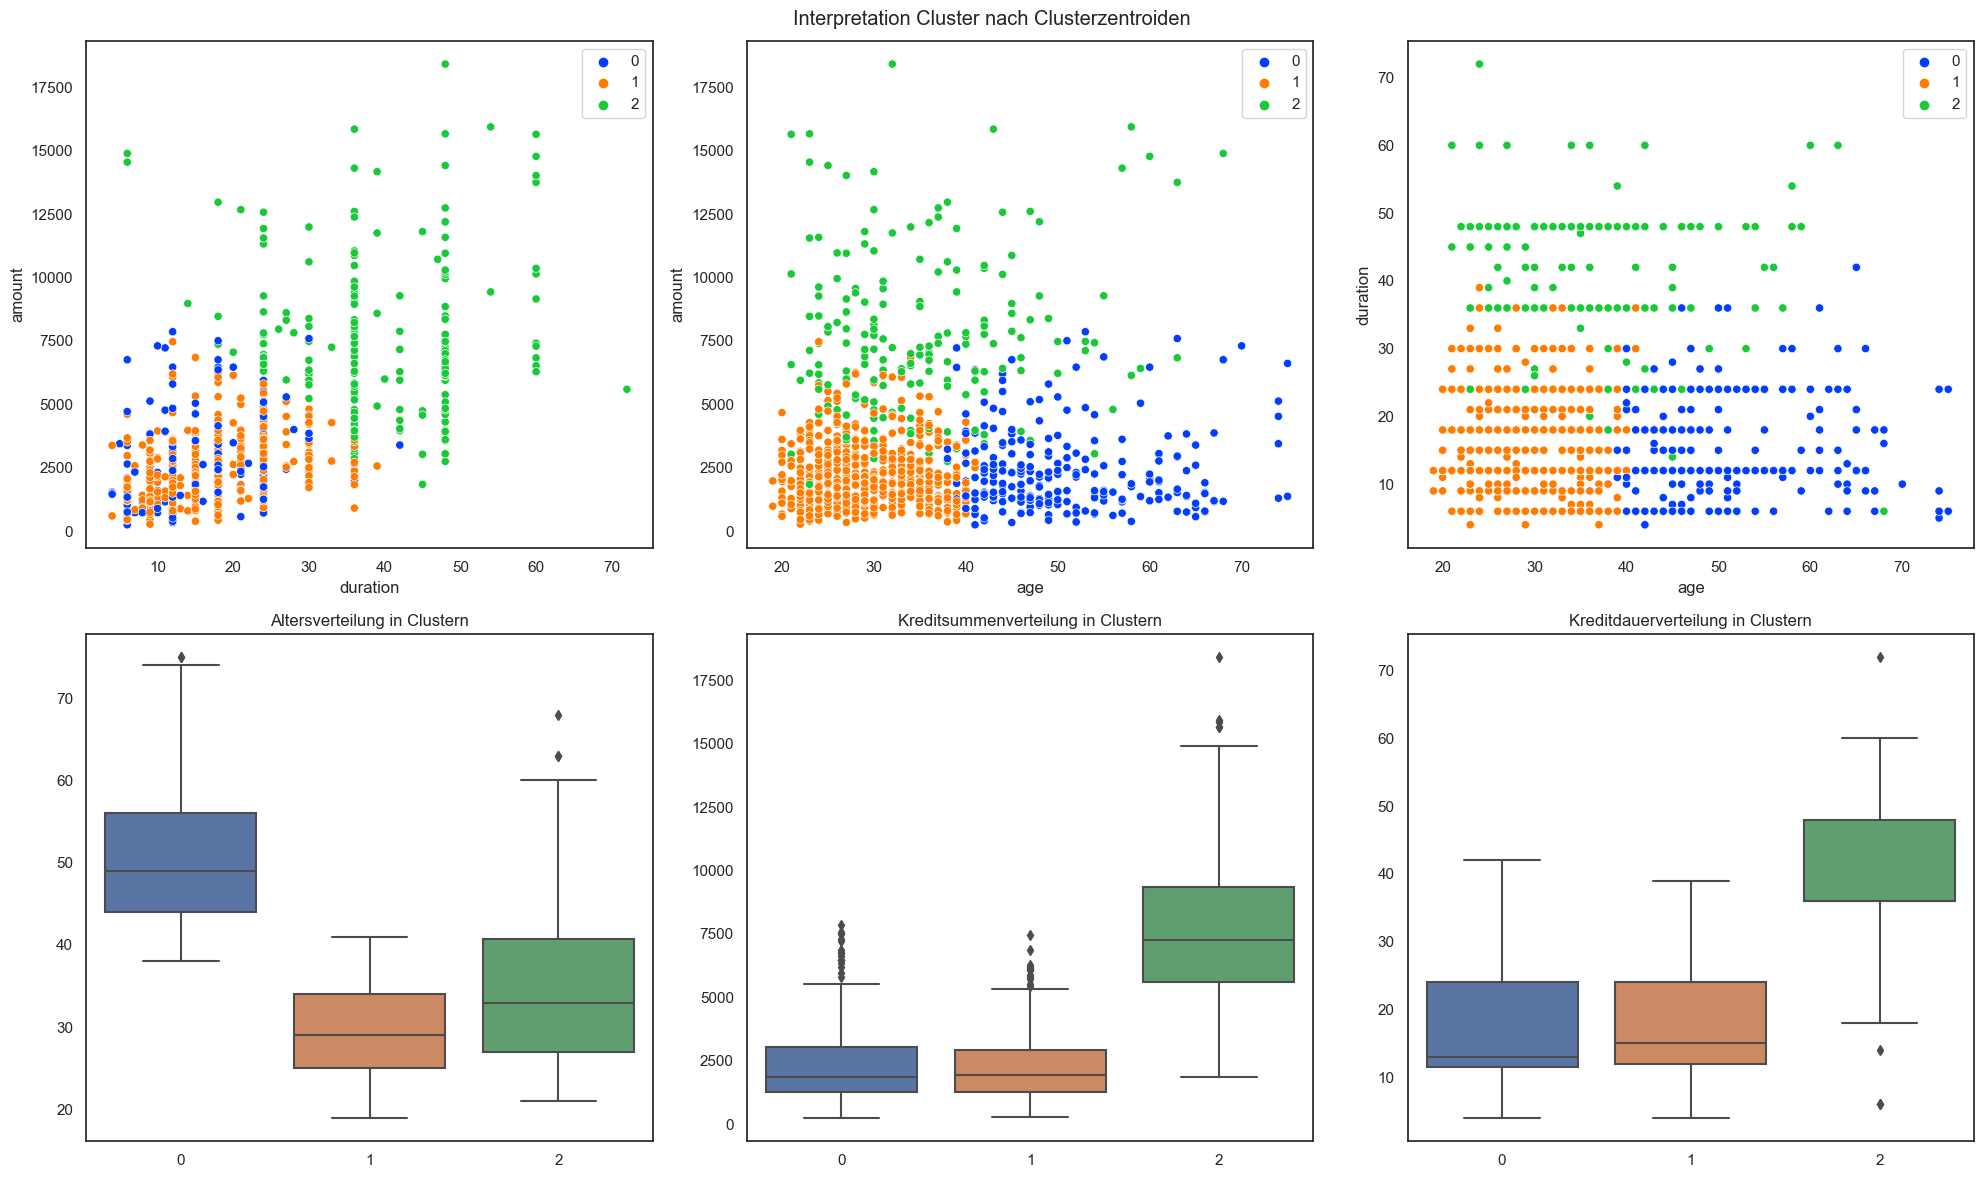

In [27]:
fig, ax  = plt.subplots(2,3,figsize=(20,12))
fig.suptitle("Interpretation Cluster nach Clusterzentroiden")
sns.scatterplot(x=df.duration, y = df.amount, hue=clusters, ax=ax[0,0], palette="bright")
sns.scatterplot(x=df.age, y = df.amount, hue=clusters, ax=ax[0,1], palette='bright')
sns.scatterplot(x=df.age, y = df.duration, hue=clusters, ax=ax[0,2], palette='bright')

ax[1,0].set_title ("Altersverteilung in Clustern")
sns.boxplot(data=[
    df[df.clusters == 0].age, 
    df[df.clusters == 1].age,
    df[df.clusters == 2].age], ax=ax[1,0])

ax[1,1].set_title ("Kreditsummenverteilung in Clustern")
sns.boxplot(data=[
    df[df.clusters == 0].amount, 
    df[df.clusters == 1].amount,
    df[df.clusters == 2].amount], ax=ax[1,1])

ax[1,2].set_title ("Kreditdauerverteilung in Clustern")
sns.boxplot(data=[
    df[df.clusters == 0].duration, 
    df[df.clusters == 1].duration,
    df[df.clusters == 2].duration], ax=ax[1,2])

plt.tight_layout()
plt.show()

### 5.3. Interpretation der Cluster
- **Cluster 0**: Alte Kreditnehmer mit kurzläufigen Kleinkrediten (1-2 Jahre, 1000-3000 EUR)
- **Cluster 1**: Junge Kreditnehmer mit kurzläufigen Kleinkrediten (1-2 Jahre, 1000-3000 EUR)
- **Cluster 2**: Eher jüngere Kreditnehmer (Mitte 30) mit längerlaufenden Großkrediten (3-4 Jahre, >5000 EUR)

### 5.4. Ausblick: 3D-Visualisierung
Anstatt der bisherigen Diagramme können auch 3D-Visualisierungen eingesetzt werden. Optional können diese animiert oder interaktiv drehbar gestaltet werden.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib qt

# Für 3D-Scatterplot Extremwerte entfernen

pltdata = df[ (df.amount   < df.amount.quantile(.95))
            & (df.age      < df.age.quantile(.95))
            & (df.duration < df.duration.quantile(.95))]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pltdata.duration, pltdata.age, pltdata.amount,
               c=pltdata.clusters, s=100, cmap="viridis")

ax.set_xlabel("Duration")
ax.set_ylabel("Age")
ax.set_zlabel("Amount")

plt.show()

In [ ]:
#Optional: Scattercube langsam rotieren
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

#### Durch Rotation des Scatter-Cubes klarer sichtbar:
- Cluster Gelb: Duration hoch ODER Amount hoch
- Cluster lila/grün: Split bei 40 Jahren und diagonal begrenzt durch Amount ODER Duration